In [347]:
# Standard library imports
import os
import sys
import re
import warnings
import random
import hashlib

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # Assuming you might need it

# Specific models and tools
from xgboost import XGBClassifier
import xgboost as xgb

# Encoding and feature selection
from category_encoders import TargetEncoder  # Fixed the import based on usage
from scipy.stats import randint, uniform

# Model persistence
from joblib import dump, load

# Miscellaneous settings
%matplotlib inline
warnings.filterwarnings('ignore')


In [348]:
content = "euro_elo_3odds_5s"

In [349]:
# Load the processed data csv into a DataFrame
df = pd.read_csv(f'data/processed/processed_data_{content}.csv')

In [350]:
# Parse the date_temp column, which is in YYYYMMDD format, into a datetime object, and store in a new column 'date_temporary'
df['date_temporary'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [351]:
# Drop columns
df.drop(columns=[ 'Ref_ID',
 #'team_form_opp',
 #'opp_shots',
 #'opp_shots_target'
 'FTR2'
 ], inplace=True)

### Date settings

In [352]:
import pandas as pd

# Get the current date dynamically
date_today = pd.Timestamp.now().normalize()  # .normalize() sets the time to 00:00:00

# Declare a date by setting day, month, and year
date_specific = pd.Timestamp(year=2024, month=4, day=16)

# Calculate the date 2 weeks ago from the current date
date_delta = date_specific - pd.DateOffset(days=14)

date_start = date_specific - pd.DateOffset(days=1000)

In [353]:
# Delete all rows where the date_temporary column is older than date_start
df = df[df['date_temporary'] >= date_start]

In [354]:
#df_validationset = df.tail(250)
#df = df.iloc[:-250]

# define df_validationset as all the rows in df where the date_temporary column is greater than date_delta
df_validationset = df[df['date_temporary'] > date_delta]

# define df as all the rows in df where the date_temporary column is less than or equal to date_delta
df = df[df['date_temporary'] <= date_delta]

In [355]:
len(df), len(df_validationset)

(15797, 298)

In [356]:
# Drop the date_temporary column
df.drop(columns=['date_temporary'], inplace=True)
df_validationset.drop(columns=['date_temporary'], inplace=True)

In [357]:
import ast
import pandas as pd

teams_dict = {}

# Assuming 'teams_dict.txt' contains the dictionary as a single string
with open(f'data/teams_dict_{content}.txt', 'r') as file:
    # Read the entire file content into a single string
    data = file.read()
    # Safely evaluate the string as a Python dictionary
    teams_dict = ast.literal_eval(data)

In [358]:
# Sort the df and df_validationset DataFrames by the 'Date', 'Div', 'Time' columns
df.sort_values(['Date', 'Div', 'Time'], inplace=True)
df_validationset.sort_values(['Date', 'Div', 'Time'], inplace=True)

# Set the 'Date' and 'FTR' column as the index
df.set_index(['Date'], inplace=True)
df_validationset.set_index(['Date'], inplace=True)

In [359]:
#import train_test_split
from sklearn.model_selection import train_test_split

# Split the data into X and y
X = df.drop('FTR', axis=1)
y = df['FTR']


X.columns = [re.sub(r'[<]', '_st_', str(col)) for col in X.columns]
X.columns = [re.sub(r'[>]', '_gt_', str(col)) for col in X.columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [360]:
X

,Div,Season,Time,DayOTW,Team_ID,Opp_ID,team_elo,opp_elo,team_hist_vs,opp_hist_vs,...,opp_avg_goals_against,team_shots,opp_shots,team_shots_target,opp_shots_target,team_avg_games,opp_avg_games,AvgH,AvgD,AvgA
Date,,,,,,,,,,,,,,,,,,,,,
20210723,0,2122,19,4,329,138,1516,1605,1.000000,1.300000,...,0.00,16.67,20.13,6.67,7.93,0.0,0.0,2.73,3.59,2.42
20210723,2,2122,19,4,306,154,1412,1576,0.000000,0.000000,...,0.00,8.67,16.33,2.53,7.60,0.0,0.0,2.62,3.47,2.57
20210724,0,2122,15,5,254,367,1473,1376,1.000000,2.000000,...,0.00,12.27,12.60,3.67,4.87,0.0,0.0,2.03,3.68,3.36
20210724,0,2122,17,5,186,307,1378,1305,0.000000,0.000000,...,0.00,11.33,0.00,4.93,0.00,0.0,0.0,1.78,3.75,4.26
20210724,0,2122,19,5,250,79,1352,1494,2.700000,0.300000,...,0.00,15.53,14.93,5.60,4.80,0.0,0.0,2.28,3.45,2.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240402,10,2324,20,1,129,241,1465,1547,1.466667,1.066667,...,2.04,15.60,11.60,6.47,5.47,1.0,1.0,2.34,3.30,3.08
20240402,15,2324,15,1,175,293,1330,1489,3.000000,0.000000,...,1.90,8.60,12.20,3.40,5.47,1.0,1.0,4.27,3.82,1.77
20240402,15,2324,18,1,21,19,1492,1450,0.866667,1.866667,...,1.33,12.67,10.93,3.53,4.40,1.0,1.0,1.92,3.45,4.01


### Hyperparameters

In [361]:
def generate_sliding_windows_by_div(X):
    grouped = X.groupby('Div')  # Group by 'Div' only
    windows = []

    for div, group in grouped:
        indices = group.index.tolist()  # Get indices of each group
        n_samples = len(indices)

        if n_samples < 2:
            print(f"Skipping division {div} with insufficient samples: {n_samples}")
            continue

        # Using 80% of data for training and the rest for testing
        split_point = int(n_samples * 0.8)
        train_indices = indices[:split_point]
        test_indices = indices[split_point:]

        if train_indices and test_indices:  # Ensure both are non-empty
            windows.append((train_indices, test_indices))

    return windows


In [362]:
def generate_sliding_windows(X, window_size, step):
    n_samples = len(X)
    windows = []
    for start_idx in range(0, n_samples - window_size + 1, step):
        end_idx = start_idx + window_size
        if end_idx > n_samples:
            break  # Avoid going beyond the dataset
        train_indices = list(range(max(0, start_idx - window_size), start_idx))
        test_indices = list(range(start_idx, end_idx))
        windows.append((train_indices, test_indices))
    return windows

In [363]:
percentile = [50, 75, 100]

# Define the hyperparameter search space
param_dist = {

    #'xgb__select__percentile': [100],
    #'gb__select__percentile': [100],
    #'lr__select__percentile': [100],
    #'ada__select__percentile': [100],
    
    'xgb__clf__max_depth': [1,2,3],
    'xgb__clf__learning_rate': [0.001, 0.01, 0.1],
    'xgb__clf__lambda': [1, 1.5, 2],  # L2 regularization term on weights
    'xgb__clf__alpha': [0, 0.5, 1],  # L1 regularization term on weights
    'xgb__clf__n_estimators': [1, 5, 100],

    'rf__clf__max_depth': [1, 2],
    #'rf__clf__min_samples_split': [2, 5],
    #'rf__clf__min_samples_leaf': [1, 2],
    #'rf__clf__bootstrap': [True, False],
    'rf__clf__n_estimators': [1, 5, 100],

    'lr__clf__C': [0.1, 1],  # Inverse of regularization strength; smaller values specify stronger regularization.
    'lr__clf__penalty': ['l1', 'l2', 'elasticnet'],  # Specify the norm of the penalty.
    'lr__clf__solver': ['saga'],  # Algorithm to use in the optimization problem, 'saga' supports all penalties.
    'lr__clf__l1_ratio': [0.5],  # The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'.
    'lr__clf__class_weight': ['balanced'],

    #'cat__clf__depth': [1,2,3,4],
    #'cat__clf__learning_rate': [0.01, 0.05, 0.1],
    #'cat__clf__iterations': [50, 100, 200],
    #'cat__clf__l2_leaf_reg': [1, 3, 5],

    'gb__clf__learning_rate': [0.01, 0.1, 0.2],
    'gb__clf__n_estimators': [50, 100, 200],
    'gb__clf__max_depth': [3, 5 , 7],
    'gb__clf__min_samples_split': [2, 5],
    'gb__clf__min_samples_leaf': [1, 2],

}


param_test = {
    
    'xgb__clf__max_depth': [1,2],
    'xgb__clf__learning_rate': [0.001, 0.01, 0.1],
    'xgb__clf__lambda': [1, 1.5, 2],  # L2 regularization term on weights
    'xgb__clf__alpha': [0, 0.5, 1],  # L1 regularization term on weights
    'xgb__clf__n_estimators': [1, 5, 100],


}

In [364]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Define a custom scoring function
def xgb_early_stopping_score(y, estimator, X, y_true, sample_weight=None):
    """
    Custom scorer that uses early stopping.
    """
    # Split X into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.2, random_state=42)
    
    # Fit with early stopping
    eval_set = [(X_val, y_val)]
    estimator.fit(X_train, y_train, early_stopping_rounds=25, eval_set=eval_set, verbose=False)
    
    # Predict on the validation set
    y_pred = estimator.predict(X_val)
    
    # Return the F1 score
    return f1_score(y_val, y_pred, pos_label=1)

In [365]:
# selection
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest

In [366]:
def safe_slice(X, indices):
    """ Safely slice the DataFrame using the provided indices, avoiding out-of-bounds errors. """
    max_idx = X.index.max()
    indices = [idx for idx in indices if idx <= max_idx]
    return X.loc[indices]


In [367]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from imblearn.pipeline import Pipeline as ImbPipeline
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

# LightGBM
from lightgbm import LGBMClassifier

# naive bayes
from sklearn.naive_bayes import GaussianNB

#catboost
from catboost import CatBoostClassifier

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Support Vector Machine
from sklearn.svm import SVC

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

# Define the F1 score for the '1' class
f1_scorer = make_scorer(f1_score, pos_label=1)

best_f1_score = 0
best_f1_params = None
best_window_size = None
best_precision = 0
best_model = None 
f1_scores = []
precision_scores = []

# Make the custom scorer
custom_scorer = make_scorer(xgb_early_stopping_score, greater_is_better=True, needs_proba=False, X=X, y_true=y)

# Set the window_size and step to 5% of the dataset
window_size = int(len(X) * 0.05)
step = int(len(X) * 0.05)

# Initialize an empty list to store precision scores
precision_scores = []

# Initialize an empty dataframe to store misclassified samples
misclassified_samples = pd.DataFrame(columns=X.columns)


# Generate windows
window_splits = generate_sliding_windows_by_div(X)

print(f"Number of windows: {len(window_splits)}")
print(f"Windows: {(window_splits)}")


# Iterate over each sliding window
for i, (train_index, test_index) in enumerate(window_splits):
    # Use loc for label-based indexing to handle non-contiguous indices correctly
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

    print(f"Iteration {i+1}: Training Data Shape - {X_train.shape}, Testing Data Shape - {X_test.shape}")


    # Combine misclassified samples from previous iterations with current training data
    if not misclassified_samples.empty:
        X_train_combined = pd.concat([X_train, misclassified_samples[X_train.columns]], axis=0)
        y_train_combined = pd.concat([y_train, misclassified_samples['FTR']], axis=0)
    else:
        X_train_combined = X_train
        y_train_combined = y_train

    # Calculate misclassification frequency
    misclassified_freq = y_train_combined.value_counts(normalize=True)

    fts = 15

    # Define pipelines for each classifier with SMOTE and TargetEncoder
    pipeline_xgb = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectKBest(chi2, k=fts)),
        ('clf', XGBClassifier(random_state=42, verbose=0))
    ])

    pipeline_gb = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectKBest(chi2, k=fts)),
        ('clf', GradientBoostingClassifier(random_state=42, verbose=0))
    ])

    # pipeline for logistic regression
    pipeline_lr = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectKBest(chi2, k=fts)),
        ('clf', LogisticRegression(random_state=42, verbose=0, multi_class='ovr'))
    ])

    # pipeline for catboost classifier
    pipeline_cat = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectKBest(chi2, k=fts)),
        ('clf', CatBoostClassifier(random_state=42, verbose=0))
    ])

    # pipeline for random forest
    pipeline_rf = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectKBest(chi2, k=fts)),
        ('clf', RandomForestClassifier(random_state=42, verbose=0))
    ])

    # LightGBM pipeline
    pipeline_lgbm = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectKBest(chi2, k=fts)),
        ('clf', LGBMClassifier(random_state=42, force_col_wise='true', verbose=0))
    ])

    # Adaboost pipeline
    pipeline_ada = ImbPipeline([
        ('target_encoder', TargetEncoder()),
        ('scaler', StandardScaler()),
        ('min_max_scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42, k_neighbors=2)),
        ('select', SelectKBest(chi2, k=fts)),
        ('clf', AdaBoostClassifier(random_state=42))
    ])


    # Combine them into an ensemble classifier
    ensemble_clf = VotingClassifier(estimators=[
        ('xgb', pipeline_xgb),
        ('gb', pipeline_gb),
        ('lr', pipeline_lr),
        #('cat', pipeline_cat),
        ('rf', pipeline_rf),
        #('lgbm', pipeline_lgbm),
        ('ada', pipeline_ada)
    ], voting='soft')

    # Setup RandomizedSearchCV
    clf = RandomizedSearchCV(
        estimator=ensemble_clf,
        param_distributions=param_dist,
        #param_distributions=param_test,
        n_iter=2,
        scoring=custom_scorer,
        cv=TimeSeriesSplit(n_splits=2),
        random_state=42,
        n_jobs=-1,
        verbose=0
    )  


    # Fit RandomizedSearchCV
    clf.fit(X_train_combined, y_train_combined)

    # Get the best parameters
    best_params = clf.best_params_
    print("Best Parameters:", best_params)

    # Use the best estimator
    best_pipe = clf.best_estimator_

    # Make predictions
    y_proba = best_pipe.predict_proba(X_test)

    y_pred = best_pipe.predict(X_test)

    best_model = clf.best_estimator_ 

    # Calculate precision score
    precision = np.mean(y_test == y_pred)
    precision_scores.append(precision)
    print("Precision:", precision)

    print()

Number of windows: 16
Windows: [([20210723, 20210724, 20210724, 20210724, 20210725, 20210725, 20210725, 20210725, 20210727, 20210730, 20210731, 20210731, 20210731, 20210731, 20210801, 20210801, 20210801, 20210801, 20210806, 20210807, 20210807, 20210807, 20210807, 20210808, 20210808, 20210808, 20210808, 20210813, 20210814, 20210814, 20210814, 20210814, 20210815, 20210815, 20210815, 20210815, 20210820, 20210821, 20210821, 20210821, 20210822, 20210822, 20210822, 20210827, 20210828, 20210828, 20210828, 20210828, 20210829, 20210829, 20210829, 20210829, 20210910, 20210911, 20210911, 20210912, 20210912, 20210912, 20210912, 20210912, 20210913, 20210917, 20210918, 20210918, 20210918, 20210918, 20210919, 20210919, 20210919, 20210919, 20210922, 20210923, 20210924, 20210925, 20210925, 20210925, 20210926, 20210926, 20210926, 20210926, 20210926, 20211001, 20211002, 20211002, 20211002, 20211002, 20211003, 20211003, 20211003, 20211003, 20211015, 20211016, 20211016, 20211016, 20211016, 20211017, 202110

### Feature Importances

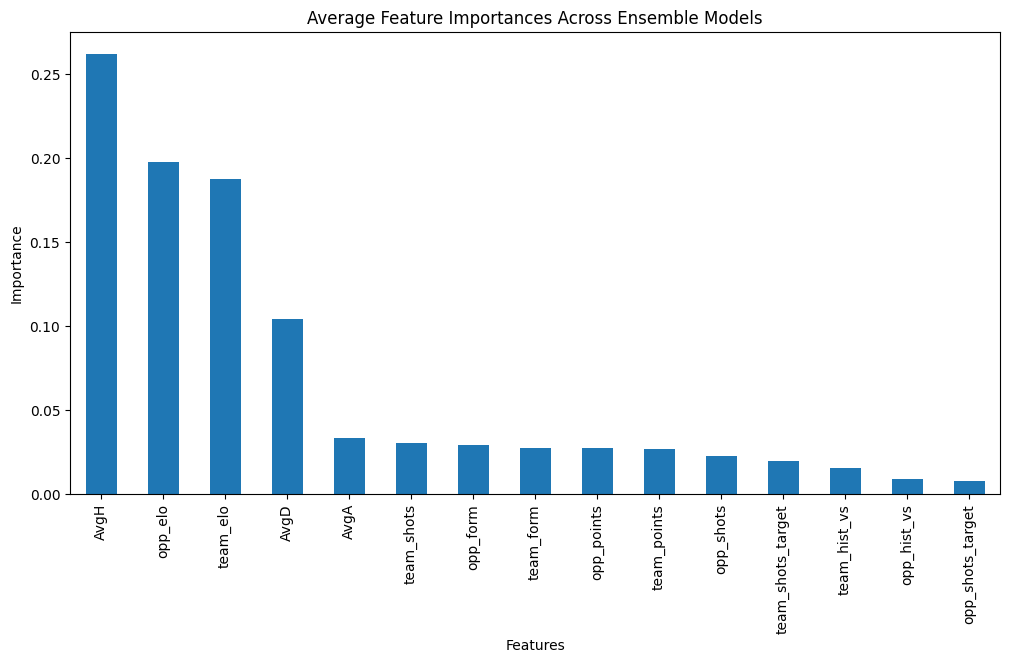

In [368]:
# %%
# Feature Importances from Ensemble Model

import matplotlib.pyplot as plt
import numpy as np

# Check if the 'best_model' is indeed a fitted VotingClassifier
if isinstance(best_model, VotingClassifier):
    # Initialize a dictionary to store feature importances
    feature_importances = {}

    # Loop through each classifier in the ensemble
    for clf_name, clf_pipeline in best_model.named_estimators_.items():
        if hasattr(clf_pipeline.named_steps['clf'], 'feature_importances_'):
            # Extract feature importances
            importances = clf_pipeline.named_steps['clf'].feature_importances_

            # Access feature names via the 'select' step in pipeline if available
            # Assuming feature selection might alter the features passed to the classifier
            if 'select' in clf_pipeline.named_steps:
                mask = clf_pipeline.named_steps['select'].get_support()  # Get the boolean mask
                feature_names = np.array(X.columns)[mask]
            else:
                feature_names = np.array(X.columns)

            # Combine feature names and their corresponding importance
            feature_importances[clf_name] = pd.Series(importances, index=feature_names)

    # Now plot the feature importances
    plt.figure(figsize=(12, 6))

    # We could either plot the average of importances or just from one classifier
    # Here's how to plot average importances:
    # First, align all Series on the same Index
    avg_importances = pd.DataFrame(feature_importances).mean(axis=1).sort_values(ascending=False)

    avg_importances.plot(kind='bar')
    plt.title('Average Feature Importances Across Ensemble Models')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()


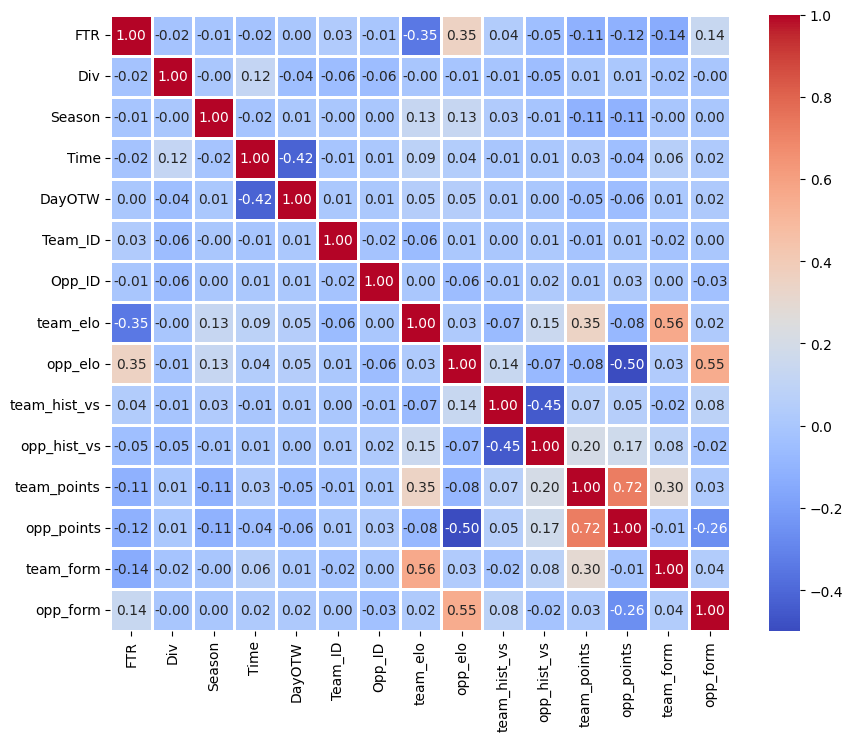

In [369]:
# Correlation matrix
corr = df.corr()

fts = 15

# Put the target column to the front
cols = list(corr.columns)
cols.insert(0, cols.pop(cols.index('FTR')))
corr = corr.loc[cols, cols]

# Sort the labels by correlation to the target
#corr = corr.sort_values(by='FTR', ascending=False)

# Limit to 10 most correlated features to the target
corr = corr.iloc[:fts, :fts]

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=2)
plt.show()



In [370]:
# Display the columns with a negative correlation with the FTR column
neg_corr = corr['FTR'] < 0
neg_corr_cols = corr.columns[neg_corr].tolist()
neg_corr_cols

['Div',
 'Season',
 'Time',
 'Opp_ID',
 'team_elo',
 'opp_hist_vs',
 'team_points',
 'opp_points',
 'team_form']

### Validation

In [371]:
def calculate_value_bet(row):
    """
    Calculate the value bet based on the model's probability and the bookmaker's odds.
    
    Parameters:
    - row: A row from a DataFrame, containing the 'Probability' and 'AvgH' columns.
    
    Returns:
    - The calculated value of the bet.
    """
    decimal_odds = row['AvgH']
    model_probability = row['Probability']
    value = (decimal_odds * model_probability) - 1
    return value

In [372]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

df_val = df_validationset.copy()

# Calculate the predicted probabilities for the validation set
y_val_proba = best_pipe.predict_proba(df_val.drop(columns=['FTR']))

In [373]:
df_val

,Div,Season,Time,DayOTW,Team_ID,Opp_ID,FTR,team_elo,opp_elo,team_hist_vs,...,opp_avg_goals_against,team_shots,opp_shots,team_shots_target,opp_shots_target,team_avg_games,opp_avg_games,AvgH,AvgD,AvgA
Date,,,,,,,,,,,,,,,,,,,,,
20240403,3,2324,19,2,26,211,0,1635,1367,0.000000,...,1.93,14.40,8.53,5.80,3.47,1.0,1.0,1.10,11.25,22.73
20240403,3,2324,19,2,58,61,1,1392,1479,2.266667,...,2.00,17.33,13.33,5.00,4.40,1.0,1.0,2.39,3.79,2.78
20240403,3,2324,20,2,218,29,0,1646,1556,2.400000,...,2.00,15.73,11.80,5.07,4.67,1.0,1.0,1.30,6.08,9.06
20240403,7,2324,17,2,249,24,0,1599,1548,1.733333,...,1.50,16.00,10.67,7.67,5.07,1.0,1.0,1.34,4.83,8.34
20240403,7,2324,17,2,256,188,0,1633,1446,1.200000,...,1.68,13.53,5.27,6.00,1.87,1.0,1.0,1.13,7.85,16.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240414,14,2324,20,6,126,168,0,1517,1485,3.000000,...,0.76,13.80,8.80,4.13,3.73,1.0,1.0,2.27,2.80,3.65
20240414,15,2324,11,6,269,65,2,1408,1517,3.000000,...,1.39,11.87,13.53,3.27,4.27,1.0,1.0,2.57,3.35,2.68
20240414,15,2324,14,6,158,175,2,1419,1349,1.500000,...,1.27,8.20,7.53,2.07,2.87,1.0,1.0,1.44,4.47,7.03


In [374]:
y_val_proba

array([[0.69709992, 0.17398645, 0.12891362],
       [0.20922742, 0.28855583, 0.50221675],
       [0.46906348, 0.28241391, 0.2485226 ],
       [0.45575824, 0.30807891, 0.23616285],
       [0.59721758, 0.24054371, 0.16223871],
       [0.2562185 , 0.38999667, 0.35378484],
       [0.19889369, 0.27497751, 0.52612881],
       [0.54538463, 0.28215798, 0.17245739],
       [0.18463896, 0.28085165, 0.53450939],
       [0.41458001, 0.35340688, 0.23201312],
       [0.55999499, 0.28318478, 0.15682023],
       [0.26154162, 0.33434191, 0.40411648],
       [0.21536055, 0.33758379, 0.44705566],
       [0.72963077, 0.16417018, 0.10619906],
       [0.36127729, 0.34790035, 0.29082234],
       [0.15926506, 0.13524763, 0.70548731],
       [0.27702045, 0.34280975, 0.38016981],
       [0.44439069, 0.30827839, 0.24733093],
       [0.18117783, 0.31311561, 0.50570656],
       [0.33493586, 0.36406399, 0.30100014],
       [0.40822942, 0.34355516, 0.24821541],
       [0.35480995, 0.37593399, 0.26925605],
       [0.

In [375]:
# Initialize variables to track the best threshold and its corresponding accuracy
best_threshold = 0.5
best_accuracy = 0

# Iterate over potential threshold values
for threshold in np.arange(0.5, 0.85, 0.001):
    # Apply the current threshold to generate predictions
    y_val_pred = (y_val_proba[:, 0] >= threshold).astype(int)
    
    # Evaluate accuracy for the current set of predictions
    accuracy = accuracy_score(df_val['FTR'], y_val_pred)
    
    # Update the best threshold and accuracy as needed
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold 

# Print the best threshold and its accuracy
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy}")

# Apply the best threshold to generate the final set of predictions
y_val_pred_best = (y_val_proba[:, 0] >= best_threshold).astype(int)

# Add the prediction probabilities and final predictions to df_val
#df_val['proba_0'] = y_val_proba[:, 0].round(3)
df_val['Probability'] = y_val_proba[:, 0].round(3)
df_val['Prediction'] = y_val_pred_best

df_val['Prob1'] = y_val_proba[:, 0].round(3)
df_val['ProbX'] = y_val_proba[:, 1].round(3)
df_val['Prob2'] = y_val_proba[:, 2].round(3)

# Directly filter df_val and add necessary columns without separate reindexing steps
#filtered_df_val = df_val[df_val['Probability'] > best_threshold].copy()

# Display all predictions
filtered_df_val = df_val.copy()

filtered_df_val.reset_index(inplace=True)

index_to_team = {v: k for k, v in teams_dict.items()}
filtered_df_val['Team'] = filtered_df_val['Team_ID'].map(index_to_team)
filtered_df_val['Opponent'] = filtered_df_val['Opp_ID'].map(index_to_team)

# Apply the calculate_value_bet function to each row in filtered_df_val to calculate the 'value bet'
filtered_df_val['Value Bet'] = filtered_df_val.apply(calculate_value_bet, axis=1).round(2)

display_columns = [
    'Div', 'Date', 'Time', 'Team', 'Opponent', 
    'team_elo', 'opp_elo',    
    'Prob1', 'ProbX', 'Prob2',
    
    'FTR',     
    'AvgH', 'AvgD', 'AvgA', 
    'Value Bet'
]



Best Threshold: 0.7360000000000002
Best Accuracy: 0.4161073825503356


In [376]:
output = filtered_df_val[display_columns]

output = output.sort_values('Date', ascending=False)

#output = output[output['Probability'] > best_threshold].copy()

In [377]:
# Sort by Div, Date, Time, Team
output.sort_values(['Div', 'Date', 'Team'], inplace=True)

In [378]:
def make_prediction(row):

    prob1 = row['Prob1']
    probX = row['ProbX']
    prob2 = row['Prob2']

    # Directly return '1' or '2' if their probabilities are greater than 0.6
    if prob1 > 0.6:
        return '1'
    if prob2 > 0.6:
        return '2'    

    # Define the expected value (probability * bookmaker's odds)
    # Calculate combined probabilities for '1X' and 'X2'
    prob1X = prob1 + probX
    probX2 = probX + prob2

    # Create a dictionary to compare probabilities with bet types
    bets = {
        '1': prob1,
        'X': probX,
        '2': prob2,
        '1X': prob1X,
        'X2': probX2
    }

    # Determine the best bet by finding the maximum probability
    best_bet = max(bets, key=bets.get)
    return best_bet


In [379]:
output['1X2'] = output.apply(make_prediction, axis=1)

In [380]:
def is_bet_correct(row):
    if row['FTR'] == 0:
        return row['1X2'] in ['1', '1X']
    elif row['FTR'] == 1:
        return row['1X2'] in ['1X', 'X', 'X2']
    elif row['FTR'] == 2:
        return row['1X2'] in ['X2', '2']
    return False

In [381]:
output['Correct'] = output.apply(is_bet_correct, axis=1)

### Results

In [382]:
output.columns

Index(['Div', 'Date', 'Time', 'Team', 'Opponent', 'team_elo', 'opp_elo',
       'Prob1', 'ProbX', 'Prob2', 'FTR', 'AvgH', 'AvgD', 'AvgA', 'Value Bet',
       '1X2', 'Correct'],
      dtype='object')

In [383]:
# Display the Correct Prediction True / False ratio, and ther percentage of correct predictions
#correct_predictions = output['Correct Prediction'].sum()
#total_predictions = len(output)
#correct_ratio = correct_predictions / total_predictions

#print(f"Best Threshold: {best_threshold:.2f}")
#print(f"Best Accuracy: {best_accuracy:.2f}")
#print()
#print(f"Total Predictions: {total_predictions}")
#print(f"Total Correct Predictions: {correct_predictions}")
#print()
#print(f"Percentage of Correct Predictions: {correct_ratio * 100:.2f}%")

In [387]:
# parse AvgH, AvgD, AvgA columns as float
output['AvgH'] = output['AvgH'].astype(float)
output['AvgD'] = output['AvgD'].astype(float)
output['AvgA'] = output['AvgA'].astype(float)

# Change the decimal sign to a comma for AvgH, AvgD, and AvgA columns
output['AvgH'] = output['AvgH'].apply(lambda x: str(x).replace('.', ','))
output['AvgD'] = output['AvgD'].apply(lambda x: str(x).replace('.', ','))
output['AvgA'] = output['AvgA'].apply(lambda x: str(x).replace('.', ','))

output['Value Bet'] = output['Value Bet'].apply(lambda x: str(x).replace('.', ','))

output['Prob1'] = output['Prob1'].apply(lambda x: str(x).replace('.', ','))
output['ProbX'] = output['ProbX'].apply(lambda x: str(x).replace('.', ','))
output['Prob2'] = output['Prob2'].apply(lambda x: str(x).replace('.', ','))

ValueError: could not convert string to float: '2,08'

In [388]:
# Map the 'FTR' back to the actual result
output['FTR'] = output['FTR'].map({0: '1', 1: 'X', 2: '2'})

In [395]:
# Timestamp
import datetime

# Get the current date and time
now = datetime.datetime.now()

# Format the current date and time as a string
timestamp = now.strftime("%Y%m%d_%H%M%S")

# save filtered_df_val[display_columns] to a CSV file
output.to_csv(f'data/predictions/predictions_{content}_{timestamp}.csv', index=False)

In [396]:
import winsound
frequency = 400  # Set Frequency To 2500 Hertz
duration = 200  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)